# Classification of Porto Metro stations
## Introduction/Business Problem

Porto Metro is one of the largest public transit systems in Portugal, being one of the crucial means of transportation for work and leisure trips in the city.

For this project, we want to look at the neighborhoods surrounding metro stations and classify them. Some neighborhoods are mostly residential, some have more business or commercial spaces surrounding them. The venues closest to a station determine why and how people use it. E.g. if there are no professional places in a neighborhood its residents are likely to travel to other areas for work. This creates daily migrations of people.

By analyzing this data we can classify stations by primary usage. This data is useful for city planners to determine where from and where to people are most likely to travel for work and leisure. This can help plan further extension of the network and find places for new development.

## Data

We’ll need data on the location of stations and on the venues closest to them.

    1. List of stations and their geographical coordinates using Foursquare API, with category = Metro Station.

    2. Foursquare API to explore venue and venue types surrounding each station. 
    
We’ll be querying the number of venues of each type in each category in a radius around each
station.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

print('Folium installed')
print('Libraries imported.')

import json
import requests
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import re

Folium installed
Libraries imported.


In [2]:
CLIENT_ID = 'SWK0MX1K11WHAYMPMHTBKAACPYGYSL1SIMOHZEALBLDATDJ2' # your Foursquare ID
CLIENT_SECRET = 'ICXUMU4S1PA32DULTLY0JO3U312R14GVFVUQ5FXJVP2J2HHX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
VERSION = '20200605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SWK0MX1K11WHAYMPMHTBKAACPYGYSL1SIMOHZEALBLDATDJ2
CLIENT_SECRET:ICXUMU4S1PA32DULTLY0JO3U312R14GVFVUQ5FXJVP2J2HHX


# List of Porto Metro stations

In [3]:
latitude=41.14961
longitude=-8.61099
radius=50000
LIMIT=100
search_query='Metro '
categories='4bf58dd8d48988d1fd931735' #Metro station


# create the API request URL
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,
categories)

try:
    results = requests.get(url).json()["response"]['venues']
except:
    pass

print (results)

[{'id': '4bbc46a0e436ef3bc35e5664', 'name': 'Metro Trindade [A,B,C,D,E,F]', 'location': {'address': 'R. de Camões', 'crossStreet': 'Lg. Dr. Tito Fontes', 'lat': 41.15211447651871, 'lng': -8.609718140360703, 'labeledLatLngs': [{'label': 'display', 'lat': 41.15211447651871, 'lng': -8.609718140360703}], 'distance': 298, 'cc': 'PT', 'city': 'Porto', 'state': 'Porto', 'country': 'Portugal', 'formattedAddress': ['R. de Camões (Lg. Dr. Tito Fontes)', 'Porto', 'Portugal']}, 'categories': [{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1593686574', 'hasPerk': False}, {'id': '4b85195af964a520f04b31e3', 'name': 'Metro Aliados [D]', 'location': {'address': 'Av. dos Aliados', 'lat': 41.14835690165787, 'lng': -8.610924716803758, 'labeledLatLngs': [{'label': 'display', 'lat': 41.14835690165787, 'lng': -8.6

In [4]:
#See data structure
results[0]

{'id': '4bbc46a0e436ef3bc35e5664',
 'name': 'Metro Trindade [A,B,C,D,E,F]',
 'location': {'address': 'R. de Camões',
  'crossStreet': 'Lg. Dr. Tito Fontes',
  'lat': 41.15211447651871,
  'lng': -8.609718140360703,
  'labeledLatLngs': [{'label': 'display',
    'lat': 41.15211447651871,
    'lng': -8.609718140360703}],
  'distance': 298,
  'cc': 'PT',
  'city': 'Porto',
  'state': 'Porto',
  'country': 'Portugal',
  'formattedAddress': ['R. de Camões (Lg. Dr. Tito Fontes)',
   'Porto',
   'Portugal']},
 'categories': [{'id': '4bf58dd8d48988d1fd931735',
   'name': 'Metro Station',
   'pluralName': 'Metro Stations',
   'shortName': 'Metro',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1593686574',
 'hasPerk': False}

## Metro data cleaning and visualization

In [5]:
station=[]
for v in results:    
    # return only relevant information for each station
    station.append([(
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) ]) 


stations = pd.DataFrame([item for station in station for item in station])
stations.columns = ['Name', 
                  'Latitude', 
                  'Longitude']

stations.head()

,Name,Latitude,Longitude
0,"Metro Trindade [A,B,C,D,E,F]",41.152114,-8.609718
1,Metro Aliados [D],41.148357,-8.610925
2,Metro São Bento [D],41.144993,-8.610923
3,Metro Faria Guimarães [D],41.157524,-8.609059
4,"Metro Bolhão [A,B,C,E,F]",41.149782,-8.605819


In [6]:
# create map of porto using latitude and longitude values
map_porto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(stations['Latitude'], stations['Longitude'], stations['Name']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_porto)  
    
map_porto

# Venues near each station

## Get main categories of venues

In [7]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
    return categories_list
        
categories_list=print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## Get Venues

In [8]:
def getNearbyVenues(categories,names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for c in categories:
        print (c[0])
        for name, lat, lng in zip(names, latitudes, longitudes):

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                c[1],
                lat, 
                lng, 
                radius, 
                LIMIT
                )

            # make the GET request
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
            except:
                pass

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                c[0],
                v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Station', 
                      'Station Latitude', 
                      'Station Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category'                                , 
                      'Venue SubCategory']


    return(nearby_venues)

In [9]:
porto_venues = getNearbyVenues(categories_list,
                               names=stations['Name'],
                                   latitudes=stations['Latitude'],
                                   longitudes=stations['Longitude']
                                  )

Arts & Entertainment
College & University
Event
Food
Nightlife Spot
Outdoors & Recreation
Professional & Other Places
Residence
Shop & Service
Travel & Transport


In [10]:
porto_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue SubCategory
0,"Metro Trindade [A,B,C,D,E,F]",41.152114,-8.609718,Cinema Trindade,41.150515,-8.611822,Arts & Entertainment,Indie Movie Theater
1,"Metro Trindade [A,B,C,D,E,F]",41.152114,-8.609718,Coliseu do Porto,41.147241,-8.605157,Arts & Entertainment,Music Venue
2,"Metro Trindade [A,B,C,D,E,F]",41.152114,-8.609718,Fantasporto,41.147710,-8.609245,Arts & Entertainment,Indie Movie Theater
3,"Metro Trindade [A,B,C,D,E,F]",41.152114,-8.609718,Maus Hábitos,41.146657,-8.605855,Arts & Entertainment,Music Venue
4,"Metro Trindade [A,B,C,D,E,F]",41.152114,-8.609718,Teatro Carlos Alberto,41.148972,-8.615094,Arts & Entertainment,Theater


## Data Cleaning and visualization

In [11]:
# one hot encoding
porto_onehot = pd.get_dummies(porto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
porto_onehot['Station'] = porto_venues['Station'] 

# move neighborhood column to the first column
fixed_columns = [porto_onehot.columns[-1]] + list(porto_onehot.columns[:-1])
porto_onehot = porto_onehot[fixed_columns]

porto_grouped = porto_onehot.groupby('Station').sum().reset_index()

porto_grouped.head()

,Station,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,"Metro 24 de Agosto [A,B,C,E,F]",15,14,0,100,23,16,37,3,61,76
1,Metro Aeroporto [E],0,0,0,27,2,3,8,0,24,41
2,Metro Aliados [D],39,36,0,100,100,69,58,9,69,80
3,Metro Araújo [C],1,3,0,5,1,4,18,2,11,2
4,"Metro Bolhão [A,B,C,E,F]",28,29,0,76,53,53,51,6,70,82


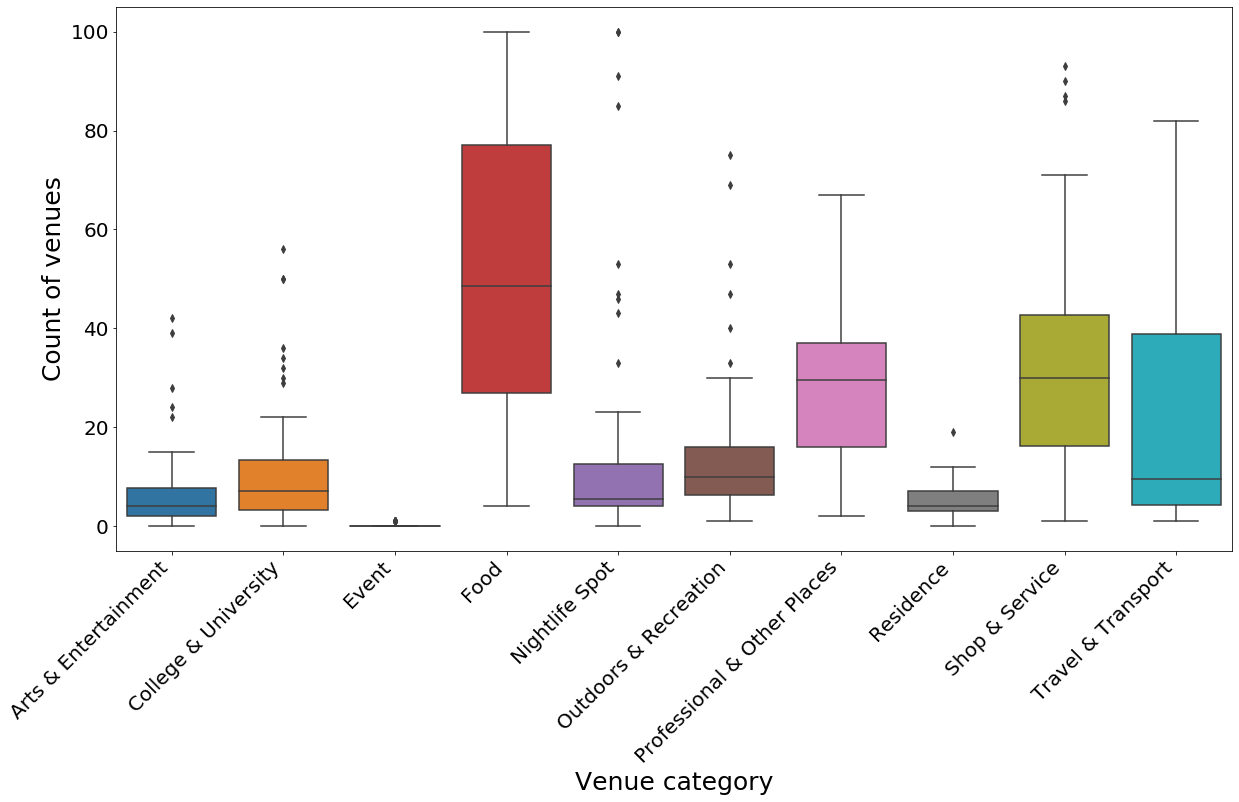

In [12]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = porto_grouped)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

# Clustering and classifying metro stations

## Preprocessing

In [13]:
from sklearn.preprocessing import MinMaxScaler

X = porto_grouped.values[:,1:]
cluster_dataset = MinMaxScaler().fit_transform(X)

cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.357143,0.250000,0.0,1.000000,0.23,0.202703,0.538462,0.157895,0.652174,0.925926
1,0.000000,0.000000,0.0,0.239583,0.02,0.027027,0.092308,0.000000,0.250000,0.493827
2,0.928571,0.642857,0.0,1.000000,1.00,0.918919,0.861538,0.473684,0.739130,0.975309
3,0.023810,0.053571,0.0,0.010417,0.01,0.040541,0.246154,0.105263,0.108696,0.012346
4,0.666667,0.517857,0.0,0.750000,0.53,0.702703,0.753846,0.315789,0.750000,1.000000


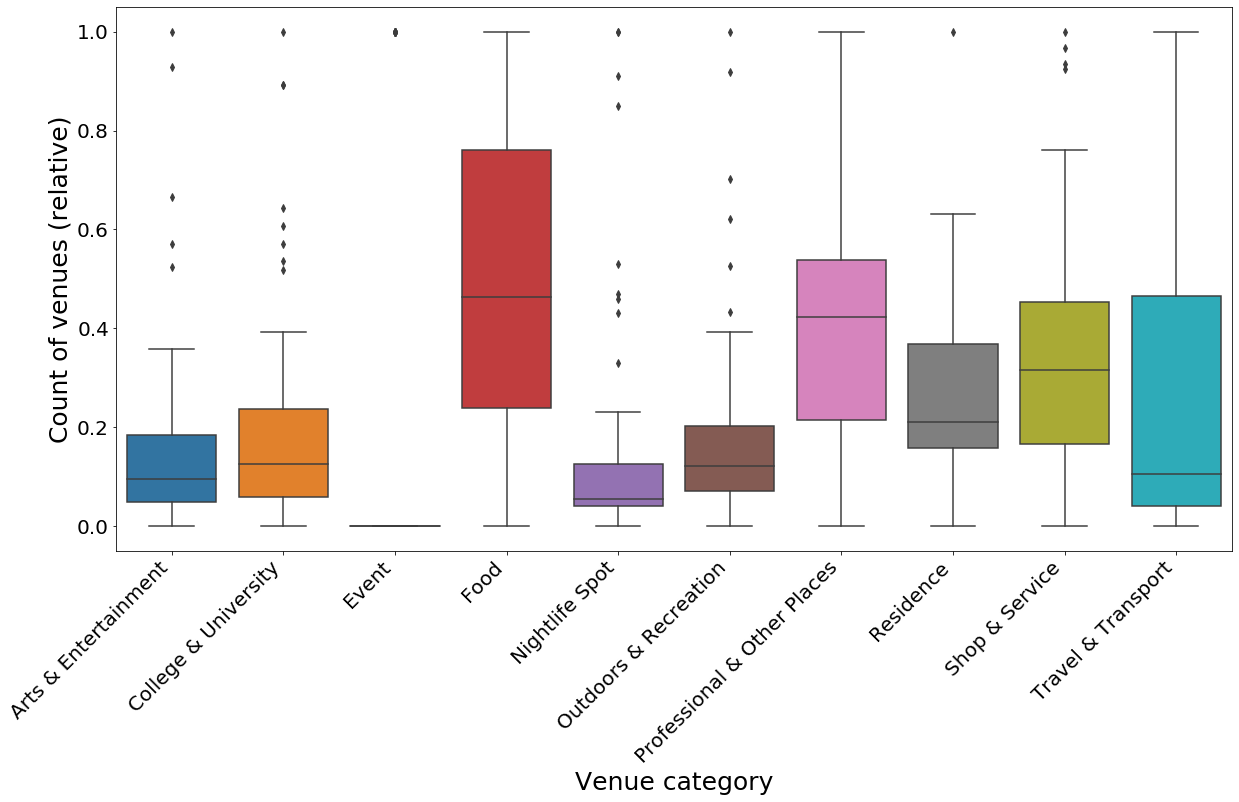

In [14]:

plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

## Clustering

In [18]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
#replace_labels = {0:2, 1:0, 2:3, 3:1}
#for i in range(len(kmeans_labels)):
#    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = porto_grouped.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['Station'] = stations['Name']
stations_clusters_minmax_df['Station Latitude'] = stations['Latitude']
stations_clusters_minmax_df['Station Longitude'] = stations['Longitude']
stations_clusters_minmax_df.head(10)

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster,Station,Station Latitude,Station Longitude
0,0.357143,0.250000,0.0,1.000000,0.23,0.202703,0.538462,0.157895,0.652174,0.925926,0,"Metro Trindade [A,B,C,D,E,F]",41.152114,-8.609718
1,0.000000,0.000000,0.0,0.239583,0.02,0.027027,0.092308,0.000000,0.250000,0.493827,1,Metro Aliados [D],41.148357,-8.610925
2,0.928571,0.642857,0.0,1.000000,1.00,0.918919,0.861538,0.473684,0.739130,0.975309,0,Metro São Bento [D],41.144993,-8.610923
3,0.023810,0.053571,0.0,0.010417,0.01,0.040541,0.246154,0.105263,0.108696,0.012346,1,Metro Faria Guimarães [D],41.157524,-8.609059
4,0.666667,0.517857,0.0,0.750000,0.53,0.702703,0.753846,0.315789,0.750000,1.000000,0,"Metro Bolhão [A,B,C,E,F]",41.149782,-8.605819
5,0.095238,0.125000,1.0,0.468750,0.13,0.162162,0.415385,0.157895,0.282609,0.098765,2,"Metro 24 de Agosto [A,B,C,E,F]",41.148956,-8.598372
6,0.023810,0.053571,0.0,0.208333,0.03,0.040541,0.215385,0.157895,0.043478,0.234568,1,"Metro Campanhã [A,B,C,E,F]",41.150438,-8.585587
7,0.047619,0.285714,1.0,1.000000,0.17,0.256757,0.553846,0.157895,0.434783,0.518519,2,"Metro Heroísmo [A,B,C,E,F]",41.146551,-8.592930
8,0.023810,0.071429,0.0,0.052083,0.05,0.027027,0.030769,0.052632,0.021739,0.037037,1,Metro Jardim do Morro [D],41.137500,-8.608351
9,0.119048,0.125000,1.0,1.000000,0.11,0.202703,0.630769,0.368421,0.510870,0.358025,2,"Metro Lapa [A,B,C,E,F]",41.156930,-8.616886


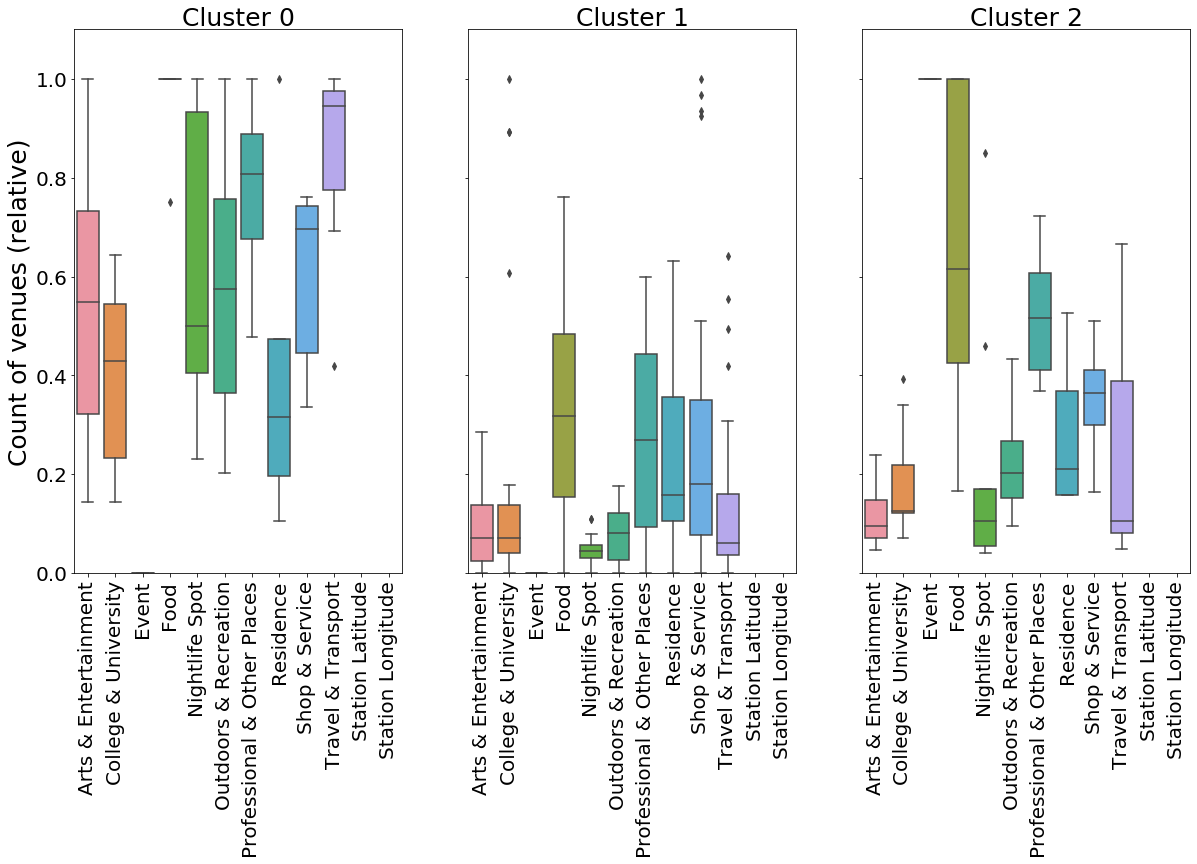

In [19]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

## Visualization

In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_clusters_minmax_df['Station Latitude'], stations_clusters_minmax_df['Station Longitude'], stations_clusters_minmax_df['Station'], stations_clusters_minmax_df['Cluster']):
    cluster=int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#  Results
Here is how we can characterize the clusters by looking at venue scores

- Cluster 0 (Red) has consistently high scores for all venue categories. This is the most diversely developed part of the city, with lots of restaurants and night life
- Cluster 1 (Purple) has balanced marks between residential, professional, food and services, being the most common type of area.
- Cluster 2 (Green) is similar tor Cluster 1, but with more food places and professional venues.


Plotting the clusters on a map shows us that

- Cluster 0 places are the most high density spots, where people tend to converge for all activities, but, in particular night life;
- Cluster 1 is scattered all over the city. As Porto doesn't have very accentuated business or residential areas, we see the mix described by this cluster to be the most common;
- Cluster 2 show places more focused on professional and food places all over the city, being areas a bit more specialized on workplaces than cluster 2.


## Discussion
To be fair, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories. Data doesn’t take into account a venue’s size (e.g. a university building attracts a lot more people that a hot dog stand – each of them is still one Foursquare “venue”).

## Conclusion
Foursquare data is limited but can provide insights into a city’s development. This data could be combined with other sources (e.g. city data on number of residents) to provide more accurate results.